## Identifying fraudulent Transactions 

This dataset loosely resembles real transactional data from capital one credit card customers, but the entities and relations within are purely fictional. No persons, places, or things lost their identity in the making of this dataset.

## Goal of the Project:
The goal of this project is to build a predictive model to determine whether a given transaction will be fraudulent or not. 
Also, analyze reversed and multi-swipe transactions to identify patterns, outliers, and significant trends across merchants and account numbers over time.

## Importing Neccessary libraries 

I am importing the jsonlines library because the data is in a text format, specifically structured as JSON Lines (where each line is a valid JSON object). The jsonlines library allows me to efficiently read and process this type of data line by line, which is particularly useful for large datasets.

In [2]:
import jsonlines
import pandas as pd
from datetime import datetime

#Read the line-delimited JSON file
data = []
with jsonlines.open("/Users/shivanikanodia/Downloads/transactions.txt") as reader:
    for obj in reader:
        data.append(obj)

#Convert to DataFrame
data = pd.DataFrame(data)

#View the DataFrame
print(data)     # Print the entire DataFrame 

       accountNumber customerId  creditLimit  availableMoney  \
0          737265056  737265056       5000.0         5000.00   
1          737265056  737265056       5000.0         5000.00   
2          737265056  737265056       5000.0         5000.00   
3          737265056  737265056       5000.0         5000.00   
4          830329091  830329091       5000.0         5000.00   
...              ...        ...          ...             ...   
786358     732852505  732852505      50000.0        48904.96   
786359     732852505  732852505      50000.0        48785.04   
786360     732852505  732852505      50000.0        48766.15   
786361     732852505  732852505      50000.0        48716.72   
786362     732852505  732852505      50000.0        48666.83   

        transactionDateTime  transactionAmount         merchantName  \
0       2016-08-13T14:27:32              98.55                 Uber   
1       2016-10-11T05:05:54              74.51          AMC #191138   
2       2016-11-08

## Exploring the data set:

In [4]:
print(data.info())  # Print a summary of the DataFrame (columns, types, etc.) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

Transaction dataset has total of **786363** entries, with total of **29** coulmns.
It has both object float and boolean data types which indicates data is mix of different set values. 

We can drop CustomerID column as it contains data which is identical to the AccountNumber column. Retaining both columns does not add value to the analysis and may lead to redundancy in further analysis. 

## Exploratory Data Analysis: 

In [6]:
# Check remaining missing values
missing_summary = data.isnull().sum()
print(missing_summary) 

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64


In [8]:
# Display the first few rows of customerId and accountNumber columns
print("First few rows of customerId and accountNumber:")
print(data[['customerId', 'accountNumber']].head())

# Check if the columns are identical
are_identical = data['customerId'].equals(data['accountNumber'])
print(f"Are 'customerId' and 'accountNumber' identical? {are_identical}") 
data[['customerId', 'accountNumber']].tail() 

data = data.drop(columns=['customerId']) 

First few rows of customerId and accountNumber:
  customerId accountNumber
0  737265056     737265056
1  737265056     737265056
2  737265056     737265056
3  737265056     737265056
4  830329091     830329091
Are 'customerId' and 'accountNumber' identical? True


The dataset has no null values and is completly clean. However there are some coulmns which are empty with no data at all for coulmns like echobuffer, merchantstate and merchantZip which I will remove from analysis as they dont add value in predicting fraudulent activity. 

In [12]:
data.describe() 

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


## From the above stastical summary we can see infer few things below:

Analyzing the dataset revealed several key insights into user behavior and financial patterns as stated below. 

-The average credit limit stands at **$10,759,** indicating that most users possess mid-level credit capacities. Interestingly, the mean available balance is lower than the credit limit, suggesting that users are actively utilizing their credit lines, with some even exceeding their limits, as evidenced by negative balances. 

-Transaction analysis shows an average amount of **$136,** with **75%** of transactions below **$191,** highlighting a tendency towards smaller purchases.

-The positive skewness in transaction amounts further underscores that while most transactions are modest, there are occasional higher-value expenditures. 

-Additionally, the presence of negative account numbers warrants further investigation to ensure data integrity and accuracy.

### Extracting date and time features for time based analyis

In [14]:

df_transactions = pd.DataFrame(data)

# Convert transactionDateTime to datetime
df_transactions['transactionDateTime'] = pd.to_datetime(df_transactions['transactionDateTime'])

# 1. Extract Time of Day (Hour)
df_transactions['transaction_hour'] = df_transactions['transactionDateTime'].dt.hour

# 2. Extract Transaction Date
df_transactions['transaction_date'] = df_transactions['transactionDateTime'].dt.date

# Display the DataFrame with new features
print(df_transactions) 

       accountNumber  creditLimit  availableMoney transactionDateTime  \
0          737265056       5000.0         5000.00 2016-08-13 14:27:32   
1          737265056       5000.0         5000.00 2016-10-11 05:05:54   
2          737265056       5000.0         5000.00 2016-11-08 09:18:39   
3          737265056       5000.0         5000.00 2016-12-10 02:14:50   
4          830329091       5000.0         5000.00 2016-03-24 21:04:46   
...              ...          ...             ...                 ...   
786358     732852505      50000.0        48904.96 2016-12-22 18:44:12   
786359     732852505      50000.0        48785.04 2016-12-25 16:20:34   
786360     732852505      50000.0        48766.15 2016-12-27 15:46:24   
786361     732852505      50000.0        48716.72 2016-12-29 00:30:55   
786362     732852505      50000.0        48666.83 2016-12-30 20:10:29   

        transactionAmount         merchantName acqCountry merchantCountryCode  \
0                   98.55                 

From the TransactionDateTime feature,  extracted the transaction hour and transaction date. These components are crucial for detecting fraudulent activities that may occur during specific peak hours, durations, or days. By breaking down the timestamp into these elements,  aim is to identify temporal patterns associated with fraudulent behavior.

In [16]:
df = df_transactions.drop('transactionDateTime', axis=1) 

In [18]:
unique_counts = df.nunique() 
unique_counts 

accountNumber                 5000
creditLimit                     10
availableMoney              521916
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5246
transactionType                  4
echoBuffer                       1
currentBalance              487318
merchantCity                     1
merchantState                    1
merchantZip                      1
cardPresent                      2
posOnPremises                    1
recurringAuthInd                 1
expirationDateKeyInMatch         2
isFraud                          2
transaction_hour                24
transaction_date    

There are 5000 Unique AccountNumber and 5 different regions and locations and 19 potential different merchants. 
There are 6 unique posEntryMode which indicates that there could be Manual Entry,  The transaction was processed using a card reader, online platform and could be via recurring billing.

In [20]:
# Data Structure and Summary
print("Number of records:", df.shape[0])
print("Number of fields per record:", df.shape[1]) 

Number of records: 786363
Number of fields per record: 29


## Data Wrangling - Duplicate transactions 

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

## Lets Explore Reverse and Multiswipe transactions and see what patterns we find: 

In [38]:
#Reversed Transaction

reversed_transactions = df[df["transactionType"]=="REVERSAL"]
print("Number of reversed_transcations ",reversed_transcations.shape[0])
print("Total value of reversed_transcations ${}".format(round(sum(reversed_transcations.transactionAmount),2))) 

Number of reversed_transcations  20303
Total value of reversed_transcations $2821792.5


A significant number of transactions (20,303) were reversed, indicating possible customer disputes or fraud detections. 
The total monetary value of these reversals is substantial ($2.82M), which could impact business operations and profitability.
If this trend is recurring, it might warrant further investigation into the reasons behind these reversals. 

Are certain merchants or accounts frequently involved in reversals?
Are specific transaction types or time periods more prone to reversals?

lets see if its the case. 

### Top Merchants Frequently Involved in Reversals

Top Merchants Involved in Reversals:
merchantName
Lyft           692
Uber           689
alibaba.com    499
ebay.com       491
oldnavy.com    488
gap.com        484
amazon.com     477
staples.com    472
target.com     469
apple.com      460
Name: count, dtype: int64


/var/folders/3_/spjvw8t50td0f_vwwrr6rs900000gn/T/ipykernel_98724/1495711005.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_merchants.values, y=top_merchants.index, palette='viridis')


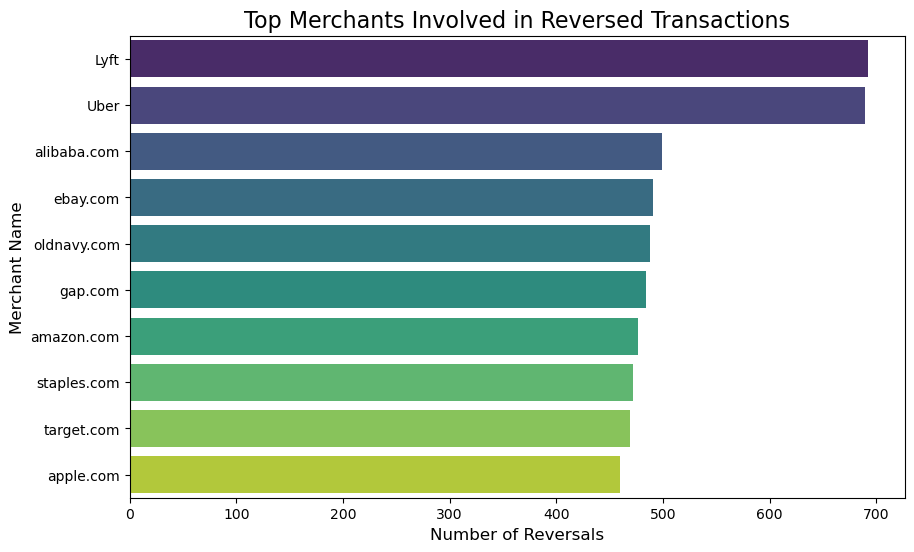

In [52]:
top_merchants = reversed_transactions['merchantName'].value_counts().head(10)
print("Top Merchants Involved in Reversals:")
print(top_merchants) 

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=top_merchants.values, y=top_merchants.index, palette='viridis')
plt.title('Top Merchants Involved in Reversed Transactions', fontsize=16)
plt.xlabel('Number of Reversals', fontsize=12)
plt.ylabel('Merchant Name', fontsize=12)
plt.show() 

## Top Accounts Frequently Involved in Reversals

Top Accounts Involved in Reversals:
accountNumber
380680241    907
882815134    384
570884863    300
246251253    277
369308035    211
894938833    181
832842201    177
724518977    173
419709514    171
208319653    148
Name: count, dtype: int64


/var/folders/3_/spjvw8t50td0f_vwwrr6rs900000gn/T/ipykernel_98724/4184200333.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_accounts.values, y=top_accounts.index, palette='plasma')


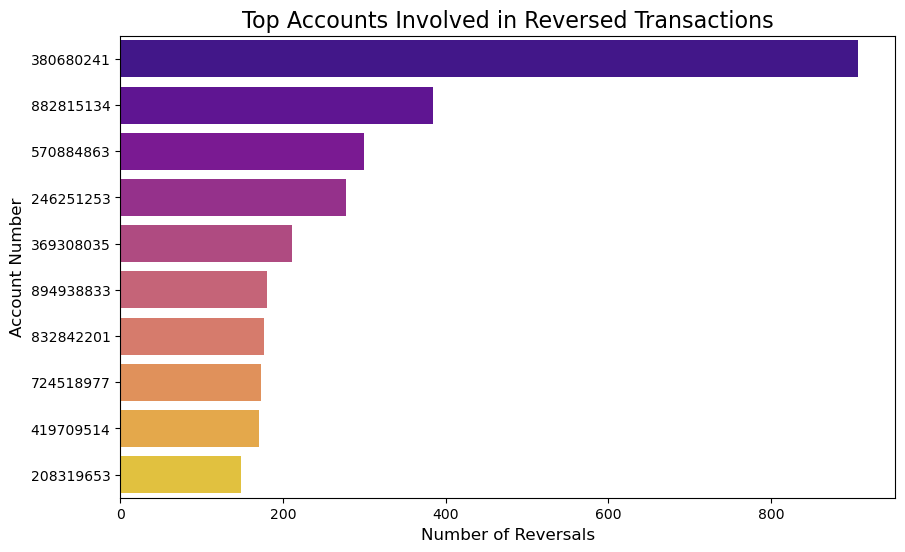

In [54]:
top_accounts = reversed_transactions['accountNumber'].value_counts().head(10)
print("Top Accounts Involved in Reversals:")
print(top_accounts) 

plt.figure(figsize=(10, 6))
sns.barplot(x=top_accounts.values, y=top_accounts.index, palette='plasma')
plt.title('Top Accounts Involved in Reversed Transactions', fontsize=16)
plt.xlabel('Number of Reversals', fontsize=12)
plt.ylabel('Account Number', fontsize=12)
plt.show() 

In [24]:
#MultiSwipe Transaction
#Logic for a MultiSwipe transaction ==> accountNumber,date, merchantName and Hour should be same

multiswipe_transcations = pd.DataFrame(df.groupby(["accountNumber","transaction_date","merchantName","transaction_hour"]).head())
print("Number of multiswipe_transcations",df.shape[0] - multiswipe_transcations.shape[0])
print("Total Amount for Multiswipe Transaction ",sum(df.transactionAmount) - sum(multiswipe_transcations.transactionAmount),"$") 

Number of multiswipe_transcations 6
Total Amount for Multiswipe Transaction  1044.109999999404 $


Only 6 transactions fall under the multi-swipe category, indicating that this is a relatively rare occurrence in the dataset.
The total monetary value associated with these transactions is $1,044.11, which is not a significant percentage of the overall transaction amounts.

## Visualization of Transaction Amounts 

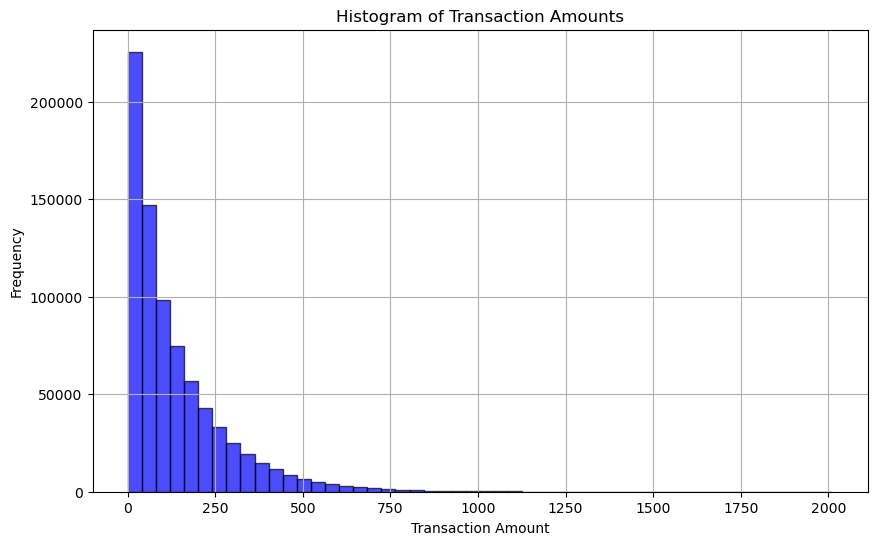

Transaction Amount Summary:
count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64


In [96]:
import matplotlib.pyplot as plt

# Plot histogram for transactionAmount
plt.figure(figsize=(10, 6))
plt.hist(df["transactionAmount"], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Statistical description of transactionAmount
transaction_stats = df["transactionAmount"].describe()
print("Transaction Amount Summary:")
print(transaction_stats)  

The histogram above illustrates the distribution of transaction amounts and their frequency. The data shows that transaction peaks occur predominantly for amounts less than **250,** with a mean transaction value of **136.** Additionally, **75%** of users spend **191** or less on their transactions, indicating that the majority of users make transactions below **200**.

In [56]:
# Remove the specified columns
columns_to_remove = ['cardLast4Digits', 'cardCVV', 'merchantCategoryCode','dateOfLastAddressChange', 'transactionDateTime', 'echoBuffer', 'enteredCVV','merchantCity', 'posConditionCode','currentExpDate', 'merchantState','merchantZip','posOnPremises','recurringAuthInd']
df_cleaned = df.drop(columns=columns_to_remove, errors='ignore') 
df_cleaned 

,accountNumber,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,accountOpenDate,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transaction_hour,transaction_date
0,737265056,5000.0,5000.00,98.55,Uber,US,US,02,2015-03-14,PURCHASE,0.00,False,False,False,14,2016-08-13
1,737265056,5000.0,5000.00,74.51,AMC #191138,US,US,09,2015-03-14,PURCHASE,0.00,True,False,False,5,2016-10-11
2,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,2015-03-14,PURCHASE,0.00,False,False,False,9,2016-11-08
3,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,2015-03-14,PURCHASE,0.00,False,False,False,2,2016-12-10
4,830329091,5000.0,5000.00,71.18,Tim Hortons #947751,US,US,02,2015-08-06,PURCHASE,0.00,True,False,False,21,2016-03-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,50000.0,48904.96,119.92,Lyft,US,US,90,2012-08-23,PURCHASE,1095.04,False,False,False,18,2016-12-22
786359,732852505,50000.0,48785.04,18.89,hulu.com,US,US,09,2012-08-23,PURCHASE,1214.96,False,False,False,16,2016-12-25
786360,732852505,50000.0,48766.15,49.43,Lyft,US,US,02,2012-08-23,PURCHASE,1233.85,False,False,False,15,2016-12-27
786361,732852505,50000.0,48716.72,49.89,walmart.com,US,US,09,2012-08-23,PURCHASE,1283.28,False,False,False,0,2016-12-29


In [58]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
encoder = LabelEncoder()

# List of categorical columns to encode
categorical_columns = ['merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'transactionType']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    df_cleaned[col] = encoder.fit_transform(df_cleaned[col])

# Display the first few rows of the encoded data
df_cleaned 

,accountNumber,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,accountOpenDate,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transaction_hour,transaction_date
0,737265056,5000.0,5000.00,98.55,2086,4,4,1,2015-03-14,2,0.00,False,False,False,14,2016-08-13
1,737265056,5000.0,5000.00,74.51,27,4,4,3,2015-03-14,2,0.00,True,False,False,5,2016-10-11
2,737265056,5000.0,5000.00,7.47,1305,4,4,3,2015-03-14,2,0.00,False,False,False,9,2016-11-08
3,737265056,5000.0,5000.00,7.47,1305,4,4,3,2015-03-14,2,0.00,False,False,False,2,2016-12-10
4,830329091,5000.0,5000.00,71.18,2084,4,4,1,2015-08-06,2,0.00,True,False,False,21,2016-03-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,50000.0,48904.96,119.92,1061,4,4,5,2012-08-23,2,1095.04,False,False,False,18,2016-12-22
786359,732852505,50000.0,48785.04,18.89,2479,4,4,3,2012-08-23,2,1214.96,False,False,False,16,2016-12-25
786360,732852505,50000.0,48766.15,49.43,1061,4,4,1,2012-08-23,2,1233.85,False,False,False,15,2016-12-27
786361,732852505,50000.0,48716.72,49.89,2487,4,4,3,2012-08-23,2,1283.28,False,False,False,0,2016-12-29


#### Converting all the variables to numeric format so we can incorporate them into our model:

In [60]:
import pandas as pd

# Ensure transaction_date and accountOpenDate are in datetime format
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['transaction_date'], errors='coerce')

# Extract features from transaction_date
df_cleaned['transaction_year'] = df_cleaned['transaction_date'].dt.year
df_cleaned['transaction_month'] = df_cleaned['transaction_date'].dt.month
df_cleaned['transaction_day'] = df_cleaned['transaction_date'].dt.day

# Drop transaction_date if no longer needed
df_cleaned.drop(['transaction_date'], axis=1, inplace=True)

# Verify that all remaining features are numeric
print(df_cleaned.dtypes) 


accountNumber                object
creditLimit                 float64
availableMoney              float64
transactionAmount           float64
merchantName                  int64
acqCountry                    int64
merchantCountryCode           int64
posEntryMode                  int64
accountOpenDate              object
transactionType               int64
currentBalance              float64
cardPresent                    bool
expirationDateKeyInMatch       bool
isFraud                        bool
transaction_hour              int32
transaction_year              int32
transaction_month             int32
transaction_day               int32
dtype: object


In [68]:
# Convert binary columns to 0 and 1
binary_columns = ['expirationDateKeyInMatch', 'isFraud', 'cardPresent']

for col in binary_columns:
    df_cleaned[col] = df_cleaned[col].astype(int)

df_cleaned = df_cleaned.drop(columns=['accountOpenDate', 'transaction_date'], errors='ignore')

# Display the first few rows of the updated data
print(df_cleaned.head()) 

  accountNumber  creditLimit  availableMoney  transactionAmount  merchantName  \
0     737265056       5000.0          5000.0              98.55          2086   
1     737265056       5000.0          5000.0              74.51            27   
2     737265056       5000.0          5000.0               7.47          1305   
3     737265056       5000.0          5000.0               7.47          1305   
4     830329091       5000.0          5000.0              71.18          2084   

   acqCountry  merchantCountryCode  posEntryMode  transactionType  \
0           4                    4             1                2   
1           4                    4             3                2   
2           4                    4             3                2   
3           4                    4             3                2   
4           4                    4             1                2   

   currentBalance  cardPresent  expirationDateKeyInMatch  isFraud  \
0             0.0            

### IMPLEMENTING RANDOM FOREST MODEL FOR PREDICTING FRAUDULENT TRANSACTIONS:

In [70]:
# Importing libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


X = df_cleaned.drop(columns=['isFraud'])  
y = df_cleaned['isFraud']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight='balanced')

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
roc_auc = roc_auc_score(y_test, y_proba)
print(roc_auc)


Confusion Matrix:
[[182884  49300]
 [  1416   2309]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    232184
           1       0.04      0.62      0.08      3725

    accuracy                           0.79    235909
   macro avg       0.52      0.70      0.48    235909
weighted avg       0.98      0.79      0.87    235909


ROC-AUC Score:
0.7754739067164274


-  True Negatives (TN): 182884
The Model correctly predicted 182884 transactions as non-fraudulent (actual non-fraud).

-  False Positives (FP): 49300
The model incorrectly predicted 49300 transactions as fraudulent (actual non-fraud).

-  False Negatives (FN): 1416
The model failed to detect 1416 fraudulent transactions (actual fraud).

-  True Positives (TP): 2309
The model correctly identified 2309 transactions as fraudulent (actual fraud).

The model predicts many non-fraudulent transactions as fraudulent, which might lead to customer dissatisfaction due to unnecessary alerts or blocks.

#### The model detects about 62% of fraudulent transactions, which is decent but can be improved and only 4.48% of transactions predicted as fraud are actually fraudulent, indicating the model struggles with accurately identifying fraud cases.

####  A high accuracy (78.46%) can be misleading in imbalanced datasets, as the majority class (non-fraud) dominates.

Further, I am going to use few strategies to maintain balance between precision and recall and to balance the dataset. 

I will Adjust the Decision Threshold, by Lowering or increasing the threshold we may help balance precision and recall based on business needs.
For Handling Class Imbalance, I will use SMOTE. 

Lets see if using these techniques will help us create a balance and how it further impacts our analysis. 

In [ ]:
#### Confusion Matrix and ROC Curve

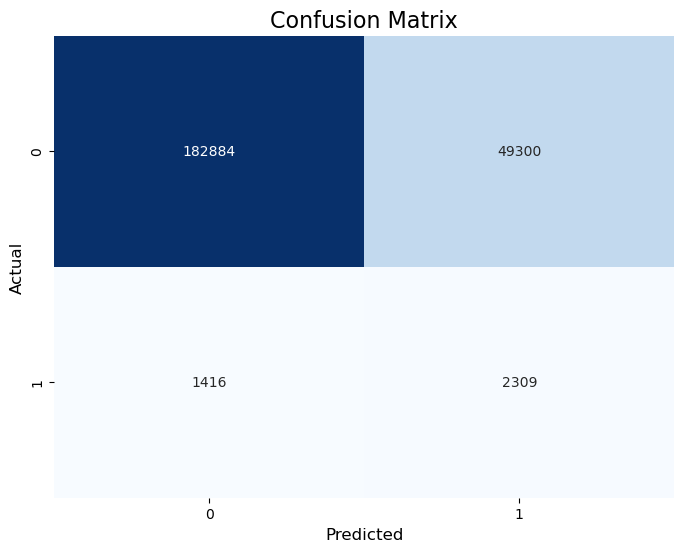

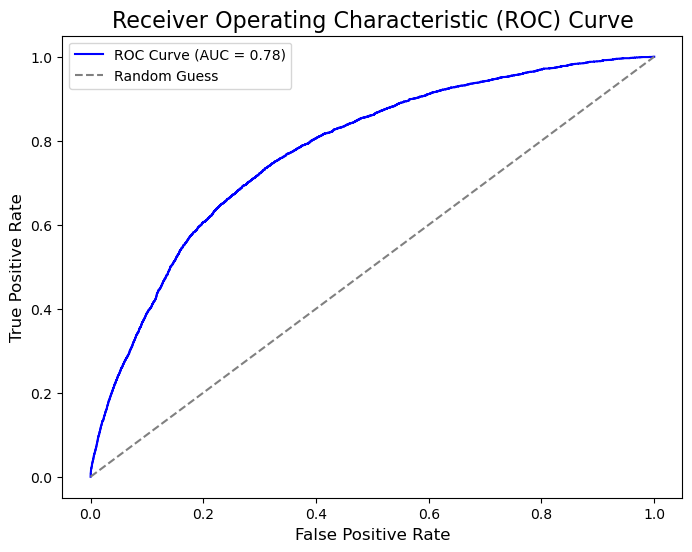

In [72]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend()
plt.show() 

In [101]:
  
X = df_cleaned.drop(columns=['isFraud'])  
y = df_cleaned['isFraud']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight='balanced')

# Train the model
rf_model.fit(X_train, y_train)

# Predict probabilities
y_probs = rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Adjust threshold
threshold = 0.6  # Set a new threshold
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Evaluate metrics
print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))

print("\nClassification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted)) 

Confusion Matrix with Adjusted Threshold:
[[204563  27621]
 [  2090   1635]]

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    232184
           1       0.06      0.44      0.10      3725

    accuracy                           0.87    235909
   macro avg       0.52      0.66      0.52    235909
weighted avg       0.98      0.87      0.92    235909



In [ ]:
**Though we have adjusted our thresold value for predicting the fraudulent and non fraudulent classes, it does not have much impact on our anaylsis, Instead the results are not much favourable (Low Precision and Recall for Class 1), So I would not use this analysis for my final Predictions.** 

In [94]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_cleaned.drop("isFraud", axis=1)
y = df_cleaned["isFraud"]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split on the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print("Class Distribution After SMOTE:")
print(y_resampled.value_counts()) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Class Distribution After SMOTE:
isFraud
0    773946
1    773946
Name: count, dtype: int64
Confusion Matrix:
[[219252  12572]
 [  4010 228534]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96    231824
           1       0.95      0.98      0.96    232544

    accuracy                           0.96    464368
   macro avg       0.96      0.96      0.96    464368
weighted avg       0.96      0.96      0.96    464368



In [ ]:
**From Above Classification report and metrics, we can say that:**


After applying SMOTE, the class distribution is balanced, which is crucial for improving the model's ability to detect fraudulent transactions without being biased toward the majority class (non-fraudulent).

**High Performance:** The model has strong performance, with high precision, recall, and F1-score for both classes (non-fraudulent and fraudulent). This indicates that the model is doing well in correctly identifying both fraudulent and non-fraudulent transactions.

**Low False Positives and False Negatives:**
False positives (non-fraudulent transactions predicted as fraudulent) are **12,572,** which is relatively low considering the large number of total non-fraudulent transactions.

False negatives (fraudulent transactions predicted as non-fraudulent) are also low, with only **4,010,** which indicates that the model is not missing many fraudulent transactions.

**Business Implications:**

**Fraud Detection:** The model is highly effective at detecting fraudulent transactions, with an **98%** recall for fraudulent transactions, which means it catches nearly all instances of fraud.

**Operational Impact:** With a high precision for both classes, the business can be confident in its predictions, reducing manual investigation time for non-fraudulent transactions while still catching most fraudulent activities.

### Why I choose to use Random Forest Model?

I have implemented Random Forest due to its ability to handle categorical and numerical data, and effectiveness in capturing non-linear relationships.
Also, It provides great tool of feature importance, which helps understand the key drivers of fradulent transactions and would help us to implement potential solutions and minimize the risk.

## lets see which features are contributing most towards fraudulent activities 

In [96]:
# Feature Importance (optional)
feature_importance = rf_model.feature_importances_
for name, importance in zip(X.columns, feature_importance):
    print(f"{name}: {importance:.4f}") 

accountNumber: 0.0936
creditLimit: 0.0306
availableMoney: 0.0451
transactionAmount: 0.3248
merchantName: 0.1263
acqCountry: 0.0027
merchantCountryCode: 0.0042
posEntryMode: 0.1489
transactionType: 0.0080
currentBalance: 0.0518
cardPresent: 0.0975
expirationDateKeyInMatch: 0.0001
transaction_hour: 0.0232
transaction_year: 0.0000
transaction_month: 0.0192
transaction_day: 0.0241



### Questions I Have? 
Are there specific thresholds or business rules for flagging transactions as fraudulent beyond model predictions?
How will the model predictions be used operationally? (e.g., real-time fraud detection or periodic reporting)
                                              
### What I Would Do Next With More Time?

**I would have used more feautures like payment Type, ProsentryMode and different time formarts to see if there are fraudulent actities for specfic times or days.** 
**Hyperparameter Tuning**
**Perform grid search or randomized search to optimize model parameters for better performance**
**Use unsupervised learning methods like clustering to detect anomalous transactions**



### Conclusion and Recommendations

From our Exploratory Data Analysis, Model Performance and Feature Importance we have below insights and Recommendations for Business. 

-  Account number, PostEntry Mode and MerchantName are them most crucial features which are prone towards fraudelent transactions.

-  If we dig deeper from our earlier visualisation we can see that Account number 380680241 have had  907 reverse transactions and (#882815134) had 384 reverse trasactions. These two accounts needs further investigation in terms of time period and freuquency of reversal within weeks or days. 

-  Also, the merchants like Lyft with  692, Uber with 689, alibaba.com with 499 and ebay.com with 491 as topmost merchant which usually are Ecommerce platform. ridesharing services and Online trading platform have most of transaction reversal, which requires further investigation and monitoring.

**Strategies and Recommendations:**
-  Implement automated flags for accounts with high reversal frequencies within a specified time window and prioritize these accounts for manual review or additional identity verification steps. Also, Analyze transaction patterns, frequency, and timing for flagged accounts to detect anomalies.

-  Develop a risk score for merchants based on the frequency of reversals, transaction volume, and customer complaints and Prioritize high-risk merchants for audits or closer monitoring. Also, Engage with high-risk merchants to understand why reversals occur (e.g., customer dissatisfaction, system errors, or fraud).

-  Set limits for high-risk merchants (e.g., cap the transaction amount or restrict bulk transactions).


## **THANKYOU**